# NLP Analysis of Disasters on Social Media

Youfei Zhang

*2019/01/01*

## 1 Executive Summary

The abundance of social media data has revolutionazed the way we approach big crisis such as earthquake and floods fundamentally. On the personal level, people who are at the frontier of those events take pictures and seek helps on social media right at the spot. On the society level, government and international organization has been trying to utilize those data to make actionable decisions in a timely manner. For instance, by analyzing tweets with searches of "earthquake", the government would be able to gain awareness of the emergencies and the urgent needs of people at different locations, and could allocate resources accordingly. 


## 2 Background




### 2.1 Objective

This project aims to anwer the following questions:

- Given a tweet, can we accurately classify it into a real disaster event from the noise?  
- Is it possible to accurately classify events with a fast algorithm? 

Building on this, I employed combinations of dfferent models and feature engineering methods. 


### 2.2 Dataset Description

This dataset is a sample from the [CrisisNLP](http://crisisnlp.qcri.org/lrec2016/lrec2016.html) dataset. It contains 2438 crisis-related Twitter data about events such as floods, earthquake, typhoon. Each tweet is labeled into one of the 5 informative classes by paid workers, with one "not related or irrelevant" class. 

There are no missing values in this dataset.

In [2]:
# load libaries

import pandas as pd
import numpy as np
import keras
import nltk
import re
import codecs

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# inspect the raw data

raw = pd.read_csv("Desktop/Code/git/NLP-for-disaster-tweets/data/sample.csv")
raw.head()

,item_id,item,label
0,'575735721744449536',Cyclone Pam hits New Zealand - dominion-post |...,Other Useful Information
1,'575736033058406400',#CylonePam devastates #Vanuatu: Regional disas...,Infrastructure and utilities
2,'575736037986578433',RT @9NewsAUS: Emergency response teams from Au...,Affected individuals
3,'575736076087644160',Vanuatu ‰_ #RT Cyclone Pam Lashes Vanuatu wit...,Other Useful Information
4,'575736131817369601',Aid agencies: Vanuatu conditions more challeng...,Other Useful Information


In [4]:
# quickly look into the lable values

class_label = raw.label.value_counts().rename('num_class').reset_index()
class_label['Percent'] = (class_label.num_class/raw.shape[0])*100
pd.DataFrame(class_label)

,index,num_class,Percent
0,Not related or irrelevant,718,29.450369
1,Other Useful Information,679,27.850697
2,Donations and volunteering,389,15.955701
3,Affected individuals,255,10.459393
4,Infrastructure and utilities,233,9.557014
5,Sympathy and support,164,6.726825


,label,% of Count
Not related or irrelevant,718,29.450369
Other Useful Information,679,27.850697
Donations and volunteering,389,15.955701
Affected individuals,255,10.459393
Infrastructure and utilities,233,9.557014
Sympathy and support,164,6.726825


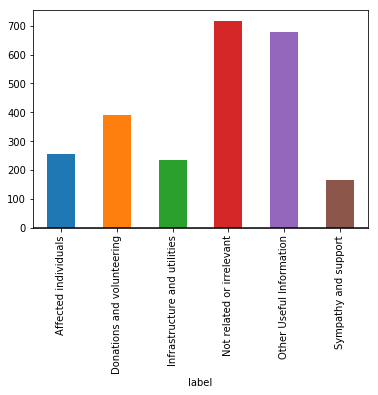

In [5]:
# define a function inspect the distribution of the data

%matplotlib inline
import matplotlib.pyplot as plt

def count_table(df, c):
        count = df[c].value_counts()
        count_percent = 100 * count / len(df)
        count_table = pd.concat([count, count_percent], axis=1)
        
        count_table.columns = [c, '% of Count']
        count_table.round(2)

        gb = df.groupby(df[c])
        targetEDA=gb[c].aggregate(len)
        
        plt.figure()
        targetEDA.plot(kind='bar', grid=False)
        plt.axhline(0, color='k')
        
        return count_table

count_table(raw, 'label')

As we can see from the plot, 'Not related or irrelevant' is the most frequent class. I am going to encode the labels into 1 and 0 later for binary classification purpose, and could expect there to be the imbalanced problem given I only have 29% of 'irrelevant'. 

## 3 Data Preprocessing

The item columns contains the raw tweets posted by the users. It is easy to see there are lots of noise when it comes to tweets data. We need to clean and tokenize these tweets to abstract useful information.

There are several issues I need to consider later: 
- 140 charaters tweets normally doesn't provide much context information
- tweets can be ambiguous given people are using informal languages and slangs

Given those issues, I have in mind that I might need to use different processing/tokenizitoin methods to deal with tweets from the methods of dealing with traditional texts. 


### 3.1 Data Cleaning

The cleaning steps is as following: 

1. normalizing to utf8 
2. lowercasing 
2. Digit -> DDD 
3. URLs -> httpAddress 
4. @username -> userID 
5. Remove special characters, keep ; . ! ? 
6. normalize elongation 

In [6]:
import re, os
import csv
import string 
import twokenize
from collections import defaultdict
import codecs
import unicodedata

In [7]:
# build a container to process the data 
# list works better here than dataframe 

columns = defaultdict(list) # each value in each column is appended to a list

with open("Desktop/Code/git/NLP-for-disaster-tweets/data/sample.csv", newline='') as f:
    reader = csv.DictReader(f) # read rows into a dictionary format
    for row in reader: # read a row as {column1: value1, column2: value2,...}
        for (k,v) in row.items(): # go over each column name and value 
            columns[k.strip()].append(v) # append the value into the appropriate list based on column name k

# columns

In [8]:
# define a function to clean the item column 

def clean_text(lst):
    clean_tweet = []
    for tweet in lst:
        print ("[original]", tweet)

        # 1. normalizing utf8 formatting 
        tweet = tweet.encode("utf8").decode("utf8")
#         tweet = tweet.encode("ascii","ignore")
        tweet = tweet.strip(' \t\n\r')
    
        # 2. lowering case 
        tweet = re.sub(' +', ' ', tweet)
        tweet = tweet.lower()
        print ("[lowercase]", tweet)

        # 3. normalizing digits
        tweet_words = tweet.strip('\r').split(' ')
        for word in [word for word in tweet_words if word.isdigit()]:
            tweet = tweet.replace(word, "D" * len(word))
        print ("[digits]", tweet)
        
        # 4. normalizing urls
        tweet_words = tweet.strip('\r').split(' ')
        for word in [word for word in tweet_words if '/' in word or '.' in word and len(word) > 3]:
            tweet = tweet.replace(word, "urls")
        print ("[urls]", tweet)
        
        #5. username 
        tweet_words = tweet.strip('\r').split(' ')
        for word in [word for word in tweet_words if word[0] == '@' and len(word) > 1]:
            tweet = tweet.replace(word, "usrId")
        print ("[username]", tweet)
        
        # 6. special characters
        punc = '@$%^&*()_+-={}[]:"|\'\~`<>/,'
        trans = str.maketrans(punc, ' '*len(punc))
        tweet = tweet.translate(trans)
        print ("[punctuation]", tweet)
        
        # 7. Normalizing +2 elongated char
        tweet = re.sub(r"(.)\1\1+",r'\1\1', tweet)
        print ("[elong]", tweet)
        
        # 8. fix \n char
        tweet = tweet.replace('\n', ' ')

        clean_tweet.append(tweet.strip())

    return clean_tweet



In [ ]:
clean = clean_text(columns['item']);

In [11]:
# write the clean text data

with open("Desktop/Code/git/NLP-for-disaster-tweets/data/sample_clean", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["item_id","item","label"])
    rows = zip(columns['item_id'], clean, columns['label'])
    for row in rows:
        writer.writerow(row)

In [12]:
data = pd.read_csv("Desktop/Code/git/NLP-for-disaster-tweets/data/sample_clean")
data.head()

,item_id,item,label
0,'575735721744449536',cyclone pam hits new zealand dominion post u...,Other Useful Information
1,'575736033058406400',#cylonepam devastates #vanuatu regional disas...,Infrastructure and utilities
2,'575736037986578433',rt usrId emergency response teams from austral...,Affected individuals
3,'575736076087644160',vanuatu ‰ #rt cyclone pam lashes vanuatu wit...,Other Useful Information
4,'575736131817369601',aid agencies vanuatu conditions more challeng...,Other Useful Information


### 3.2 Data Preparation

After we have the clean text data, there are several things we need to do:

* encodding: "Not related or irrelevant" as 0, others as 1
* split the data into train and test
* tokenization using [NLTK](https://www.nltk.org) or [tweetNLP](http://www.ark.cs.cmu.edu/TweetNLP)

For a better understanding of NLTK, here is the book from it's creator: [Natural Language Processing with Python](http://www.nltk.org/book). 

In [13]:
# tokenize the data with nltk

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

data["tokens"] = data["item"].apply(tokenizer.tokenize)
data.head()

,item_id,item,label,tokens
0,'575735721744449536',cyclone pam hits new zealand dominion post u...,Other Useful Information,"[cyclone, pam, hits, new, zealand, dominion, p..."
1,'575736033058406400',#cylonepam devastates #vanuatu regional disas...,Infrastructure and utilities,"[cylonepam, devastates, vanuatu, regional, dis..."
2,'575736037986578433',rt usrId emergency response teams from austral...,Affected individuals,"[rt, usrId, emergency, response, teams, from, ..."
3,'575736076087644160',vanuatu ‰ #rt cyclone pam lashes vanuatu wit...,Other Useful Information,"[vanuatu, rt, cyclone, pam, lashes, vanuatu, w..."
4,'575736131817369601',aid agencies vanuatu conditions more challeng...,Other Useful Information,"[aid, agencies, vanuatu, conditions, more, cha..."


[tweetNLP](https://github.com/myleott/ark-twokenize-py) is a tokenizer developed for Twitter text. As mentioned earlier, tweets are shorter and more ambiguous than regular texts. I'd like to try if tweetNLP give me more information.


Quoted from twokenize.py:

> (1) Brendan O'Connor wrote original version in Python <br>
       [TweetMotif: Exploratory Search and Topic Summarization for Twitter](http://github.com/brendano/tweetmotif)<br>
       [Brendan O'Connor, Michel Krieger, and David Ahn.
       ICWSM-2010 (demo track)](http://brenocon.com/oconnor_krieger_ahn.icwsm2010.tweetmotif.pdf)<br>
       
> (2a) Kevin Gimpel and Daniel Mills modified it for POS tagging for the CMU ARK Twitter POS Tagger <br>

> (2b) Jason Baldridge and David Snyder ported it to Scala

> (3) Brendan bugfixed the Scala port and merged with POS-specific changes for the CMU ARK Twitter POS Tagger  

> (4) Tobi Owoputi ported it back to Java and added many improvements (2012-06)



In [14]:
# look into the tokens 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
vocab = sorted(list(set(all_words))) # get rid of duplicates words by set

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(vocab)))
print("Max sentence length is %s" % max(sentence_lengths))


38173 words total, with a vocabulary size of 5619
Max sentence length is 32


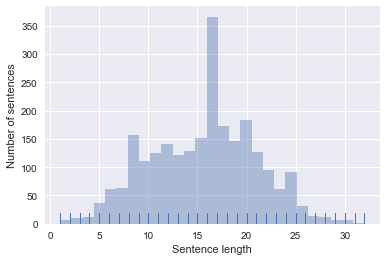

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
sns.distplot(sentence_lengths, kde=False, rug=True)

From here, we know that the length of the tweets are centered around 15 - 20 words. 

## 4 Model Training

### Enbeddings

Next step, we need to encode texts in order to feed them into algorithms. 

Embedding is the process of "learning a distributed representation for words". There are different practices, and I'll start from the simplest and the traditional one, and try other methods out later.


### 4.1 Bag of Words (BoW)

Bag of words is a model that simply count the number of each word in each sentence, and represent a sentence with 0 and 1. With this model, we will get a very sparse matrix with each row indicate each sentence and columns obtained from the words.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def emb(data):
    count_vectorizer = CountVectorizer()
    embedding = count_vectorizer.fit_transform(data)
    return embedding, count_vectorizer


In [17]:
# encode the class lable into 1 and 0 
# Not related or irrelevant = 0 

data['label_binary'] = [0 if x == 'Not related or irrelevant' else 1 for x in data.label]
data.head()

,item_id,item,label,tokens,label_binary
0,'575735721744449536',cyclone pam hits new zealand dominion post u...,Other Useful Information,"[cyclone, pam, hits, new, zealand, dominion, p...",1
1,'575736033058406400',#cylonepam devastates #vanuatu regional disas...,Infrastructure and utilities,"[cylonepam, devastates, vanuatu, regional, dis...",1
2,'575736037986578433',rt usrId emergency response teams from austral...,Affected individuals,"[rt, usrId, emergency, response, teams, from, ...",1
3,'575736076087644160',vanuatu ‰ #rt cyclone pam lashes vanuatu wit...,Other Useful Information,"[vanuatu, rt, cyclone, pam, lashes, vanuatu, w...",1
4,'575736131817369601',aid agencies vanuatu conditions more challeng...,Other Useful Information,"[aid, agencies, vanuatu, conditions, more, cha...",1


In [18]:
# seperate train and test

x = data['item'].tolist()
y = data['label_binary'].tolist()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=30)

print("length of X_train: %d, X_text: %d, y_train: %d, y_test: %d" % (len(X_train), len(X_test), len(y_train), len(y_test)))


length of X_train: 1706, X_text: 732, y_train: 1706, y_test: 732


In [19]:
# apply BoW
X_train_counts, count_vectorizer = emb(X_train)
X_test_counts = count_vectorizer.transform(X_test)

We'd like to visualy inspect this dataset by reducing the dimensionality. Here we apply latent semantic analysis [(LSA)](http://mccormickml.com/2016/03/25/lsa-for-text-classification-tutorial/) which perform linear dimensionality reduction on the text data. 

In [20]:
from sklearn.decomposition import PCA, TruncatedSVD

# reduce the dimensionality 
svd = TruncatedSVD(n_components=2)
svd.fit(X_train_counts)
lsa_bow = svd.transform(X_train_counts)
               
lsa_bow

array([[ 1.74854608, -0.98273771],
       [ 3.16633355,  0.5025919 ],
       [ 1.81532776, -0.96086198],
       ...,
       [ 2.72933314,  0.26140485],
       [ 1.87048045, -0.73577092],
       [ 1.39287886,  0.51325008]])

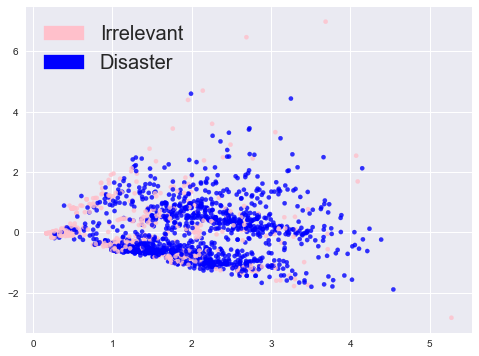

In [22]:
# visualize the word vectors
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches

def plot_LSA(y_train, lsa_scores):
        color_mapper = {label:idx for idx, label in enumerate(set(y_train))}
        color_column = [color_mapper[label] for label in y_train]
        colors = ['pink','blue']

        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=18, alpha=.8, c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='pink', label='Irrelevant')
        green_patch = mpatches.Patch(color='blue', label='Disaster')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 20})

fig = plt.figure(figsize=(8, 6))      
plot_LSA(y_train, lsa_bow)
plt.show()

Here I'd like to take a quick look into how well bag of words perform for this dataset by fitting 

In [23]:
# try it out on logistic regression 

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)


In [24]:
from sklearn import metrics

def metrics_df(y_test, y_predicted):
    
    test_accuracy = metrics.accuracy_score(y_test, y_predicted)
    test_recall = metrics.recall_score(y_test, y_predicted)
    test_precision = metrics.precision_score(y_test, y_predicted)
    test_f1 = metrics.f1_score(y_test, y_predicted)
    
#     train_accuracy_score_list = metrics.accuracy_score(train_Y,train_predictions)
#     train_recall_score_list = []
#     train_precision_score_list = []
#     train_f1_score_list = []
    
    cm = metrics.confusion_matrix(y_test,  y_predicted)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    class_0_accuracy = cm.diagonal()[0]
    class_1_accuracy = cm.diagonal()[1]
    
    results_df = pd.DataFrame(index=['accuracy','recall','precision','f1'])
    results_df['test'] = [test_accuracy, test_recall,
                           test_precision, test_f1]
    results_df['class_0_test'] = [class_0_accuracy,'-','-','-']
    results_df['class_1_test'] = [class_1_accuracy,'-','-','-']
    
    return results_df
    

In [25]:
metrics = metrics_df(y_test, y_predicted_counts)
metrics

,test,class_0_test,class_1_test
accuracy,0.864754,0.723214,0.927165
recall,0.927165,-,-
precision,0.883677,-,-
f1,0.904899,-,-


It seems performing well simply from those number. But number are meaningless without the syntax, which is why I'd like to look furthur into the confusion matrix. 

In [26]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=30)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

    return plt

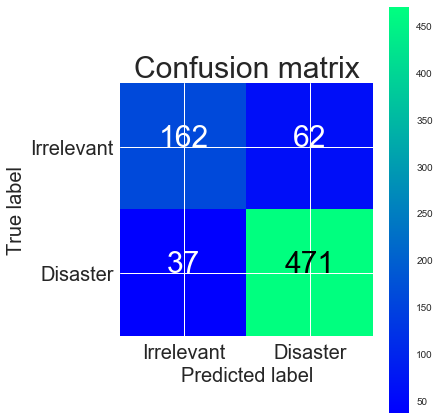

In [27]:
cm = confusion_matrix(y_test, y_predicted_counts)

fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()

In [28]:
cm_df = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
cm_df

,0,1
0,0.723214,0.276786
1,0.072835,0.927165


From the confusion matrix, it seems the classifier is doing well in predicting true disaster (92% true positive). 

It's easy to see that about 27% percent of irrelevant events are misclassified into disasters (false positive), and about 7% disasters are misclassified into irrelevant events (false negative). 

Different events here have significant differences in terms of costs. For example in the case of an earthquake, misclassifying disaster into irrelevant event could potentially lead to the delay for the government to take actions. We'd really like to see if we could furthur reduce the false negative and false positive. 

### Feature Importance

In [29]:
def get_most_important_features(vectorizer, model, n):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)
importance

{0: {'bottom': [(-1.6691399786955383, 'rushing'),
   (-1.6700549487450655, 'arrives'),
   (-1.6713901649334875, 'aftermath'),
   (-1.6900553628617707, 'saves'),
   (-1.696493036337124, 'grier'),
   (-1.8152872039549723, 'elcho'),
   (-1.8378329414205328, 'olwyn'),
   (-2.0594717703336767, 'let'),
   (-2.3833698679351563, 'shared'),
   (-2.4179741403324586, 'lawrence')],
  'tops': [(1.71919141459187, 'support'),
   (1.7391980280356802, 'bomb'),
   (1.7687393678468852, 'near'),
   (1.8505969029137772, 'damn'),
   (1.8518351895847551, 'life'),
   (1.9135061669150941, 'donate'),
   (1.9516313340830542, 'mercy'),
   (1.9778178660119696, 'cyclonepam'),
   (2.861201541388101, 'found'),
   (2.9766231183064424, 'prayers')]}}

In [30]:
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

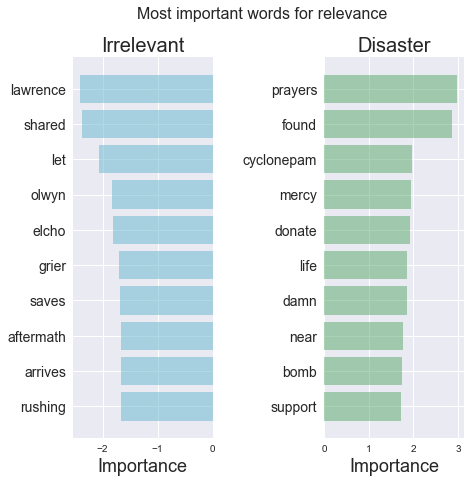

In [31]:
# plot out the importance 

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(7, 7))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5, color = 'c')
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=18)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5, color = 'g')
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=18)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()


plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

### 4.2 TF-IDF

TFIDF (Term Frequency, Inverse Document Frequency) is a commonly used practice for building word vector based their frequency. Each of the word will be normalized by its frequency in the whole corpus, more frequent words will have less weights since they are being considered addding noise. 

In [32]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [33]:
from sklearn.decomposition import PCA, TruncatedSVD

# reduce the dimensionality 
svd = TruncatedSVD(n_components=2)
svd.fit(X_train_tfidf)
lsa_tfidf = svd.transform(X_train_tfidf)
               
lsa_tfidf

array([[ 0.1338861 , -0.07708848],
       [ 0.2854792 ,  0.10836248],
       [ 0.05545341, -0.01837027],
       ...,
       [ 0.26468194,  0.00919787],
       [ 0.20597961, -0.20600758],
       [ 0.23947147,  0.12880258]])

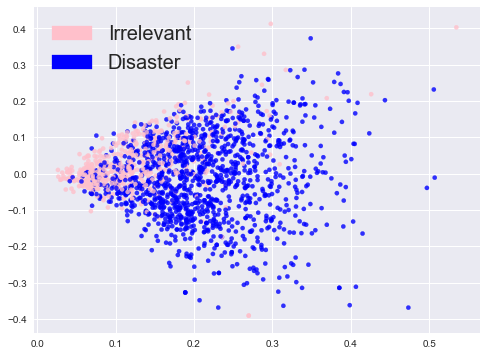

In [34]:
fig = plt.figure(figsize=(8, 6))         
plot_LSA(y_train, lsa_tfidf)
plt.show()

From this graph, we can see that the embedding with tfidf looks more seperable from bag of words. 

In [35]:
# try it out on logistic regression 

from sklearn.linear_model import LogisticRegression

clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)


In [37]:
from sklearn import metrics

def metrics_df(y_test, y_predicted):
    
    test_accuracy = metrics.accuracy_score(y_test, y_predicted)
    test_recall = metrics.recall_score(y_test, y_predicted)
    test_precision = metrics.precision_score(y_test, y_predicted)
    test_f1 = metrics.f1_score(y_test, y_predicted)
    
#     train_accuracy_score_list = metrics.accuracy_score(train_Y,train_predictions)
#     train_recall_score_list = []
#     train_precision_score_list = []
#     train_f1_score_list = []
    
    cm = metrics.confusion_matrix(y_test,  y_predicted)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    class_0_accuracy = cm.diagonal()[0]
    class_1_accuracy = cm.diagonal()[1]
    
    results_df = pd.DataFrame(index=['accuracy','recall','precision','f1'])
    results_df['test'] = [test_accuracy, test_recall,
                           test_precision, test_f1]
    results_df['class_0_test'] = [class_0_accuracy,'-','-','-']
    results_df['class_1_test'] = [class_1_accuracy,'-','-','-']
    
    return results_df
    
metrics_df(y_test, y_predicted_tfidf)

,test,class_0_test,class_1_test
accuracy,0.862022,0.700893,0.933071
recall,0.933071,-,-
precision,0.876155,-,-
f1,0.903718,-,-


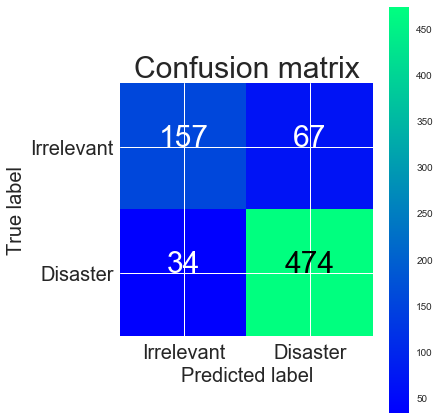

TFIDF confusion matrix
[[157  67]
 [ 34 474]]
BoW confusion matrix
[[162  62]
 [ 37 471]]


In [40]:
cm_tfidf = confusion_matrix(y_test, y_predicted_tfidf)

fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm_tfidf, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm_tfidf)

print("BoW confusion matrix")
print(cm)

As we can see our false negative decreased, while false positive increased. 

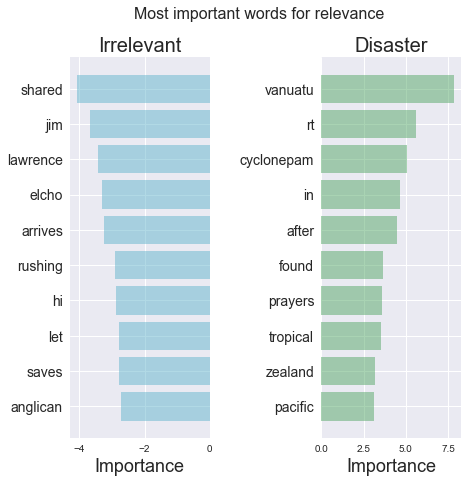

In [41]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

From confusion metric and feature importance, I don't see much improvement with TFIDF than BoW. And TFIDF actually introduced more noise and overfitting, as we can see we have more irrelevant words here than BoW. 

### 4.3 Word2vec

BoW and TFIDF are based on word frequency, and both don't take consideration of semantic meaning of the words. Another embedding model that captures semantic is [Word2vec](https://code.google.com/archive/p/word2vec/) released by Google. It is a pre-trained model that measure semantic by comparing the distance between words, and contains 300 dimensional vectors for 3 million words and phrases. 

Note: since this is a very large model, it is recommend to train it with 64-bit Python.


In [71]:
# load the pre-trained model 
import gensim

# Load Google's pre-trained Word2Vec model.
word2vec_path = "Desktop/Code/git/NLP-for-disaster-tweets/GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)  

In [105]:
# get sentence embeddings by averaging average word2vec score
import numpy as np

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
        
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, data, generate_missing=False):
    embeddings = data['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)


In [106]:
embeddings = get_word2vec_embeddings(word2vec, data)
embeddings = np.array(embeddings)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, y, test_size=0.3, random_state=40)

print("length of X_train: %d, X_text: %d, y_train: %d, y_test: %d" % (len(X_train_word2vec), len(X_test_word2vec), len(y_train_word2vec), len(y_test_word2vec)))

length of X_train: 1706, X_text: 732, y_train: 1706, y_test: 732


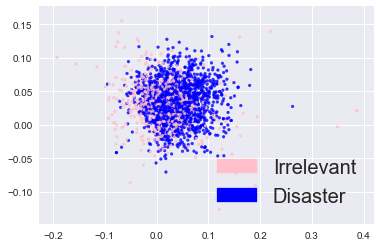

In [107]:
color_mapper = {label:idx for idx, label in enumerate(set(y))}
color_column = [color_mapper[label] for label in y]
colors = ['pink','blue']

plt.scatter(embeddings[:,0], embeddings[:,1], s=8, alpha=.8, c=y, cmap=matplotlib.colors.ListedColormap(colors))
red_patch = mpatches.Patch(color='pink', label='Irrelevant')
green_patch = mpatches.Patch(color='blue', label='Disaster')
plt.legend(handles=[red_patch, green_patch], prop={'size': 20})


fig = plt.figure(figsize=(15, 15))      
plt.show()

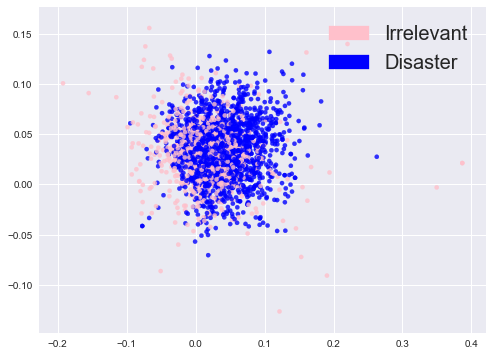

In [108]:
fig = plt.figure(figsize=(8, 6))         
plot_LSA(y, embeddings)
plt.show()

In [109]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [110]:
metrics_df(y_test, y_predicted_tfidf)

,test,class_0_test,class_1_test
accuracy,0.862022,0.700893,0.933071
recall,0.933071,-,-
precision,0.876155,-,-
f1,0.903718,-,-


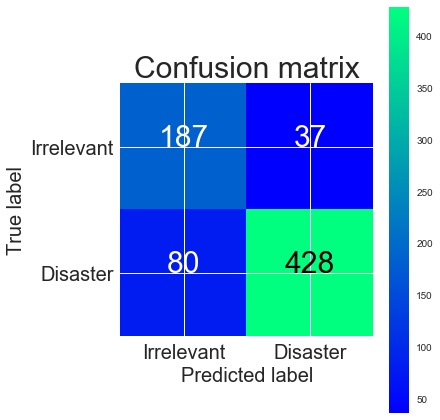

In [114]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)

fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm_w2v, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()

In [112]:
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm_tfidf)
print("BoW confusion matrix")
print(cm)

Word2Vec confusion matrix
[[187  37]
 [ 80 428]]
TFIDF confusion matrix
[[157  67]
 [ 34 474]]
BoW confusion matrix
[[162  62]
 [ 37 471]]


### LIME to interpret word2vec

In [116]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(x, y, test_size=0.2, 
                                                                                random_state=40)
vector_store = word2vec

In [118]:
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [119]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["irrelevant","relevant", "unknown"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [120]:
visualize_one_exp(X_test_data, y_test_data, 65)

/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Index: 65
True class: relevant


In [121]:
visualize_one_exp(X_test_data, y_test_data, 60)

/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Index: 60
True class: irrelevant


In [122]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions



In [ ]:
label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

In [ ]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

## 5 Neural Nets Models

### 5.1 CNNs 

Here I'd like to try some deep learning models to capture sentence structures.

In [124]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(vocab)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(data["item"].tolist())
sequences = tokenizer.texts_to_sequences(data["item"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 5823 unique tokens.


In [125]:
cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(data['label_binary']))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)

print(embedding_weights.shape)

(5824, 300)


In [130]:
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [131]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(data['label_binary'].unique())), False)

In [132]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Train on 1951 samples, validate on 487 samples
Epoch 1/3
1951/1951 [==============================] - 4s 2ms/step - loss: 0.7569 - acc: 0.6802 - val_loss: 0.5766 - val_acc: 0.7002
Epoch 2/3
1951/1951 [==============================] - 4s 2ms/step - loss: 0.5543 - acc: 0.7242 - val_loss: 0.5322 - val_acc: 0.7495
Epoch 3/3
1951/1951 [==============================] - 4s 2ms/step - loss: 0.4458 - acc: 0.7970 - val_loss: 0.3924 - val_acc: 0.8480


## Reference:

1. http://crisisnlp.qcri.org/lrec2016/lrec2016.html
2. [Natural Language Processing with Python](http://www.nltk.org/book)
3. [Dataset Github](http://github.com/CrisisNLP/deep-learning-for-big-crisis-data)
4. [tweetNLP](http://www.ark.cs.cmu.edu/TweetNLP)
5. [3 silver bullets of word embeddings in NLP](https://towardsdatascience.com/3-silver-bullets-of-word-embedding-in-nlp-10fa8f50cc5a)
6. [Word2vec](https://code.google.com/archive/p/word2vec/)
7. [Google's trained Word2Vec model in Python](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/)